In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [465]:
GSPC = pd.read_csv('GSPC_index_close_test123.csv')
GSPC['Date']=pd.to_datetime(GSPC['Date'])
GSPC.set_index('Date', inplace=True)
GSPC=GSPC.T
GSPC_noisy = pd.DataFrame(np.repeat(GSPC.values,100,axis=0), columns=GSPC.columns)
#GSPC_noisy=GSPC_noisy.iloc[:, 52:]
GSPC_noisy

Date,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
0,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
1,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
2,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
3,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
4,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
96,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
97,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098
98,2257.830078,2270.75,2269.0,2276.97998,2268.899902,2268.899902,2275.320068,2270.439941,2274.639893,2267.889893,...,2545.939941,2546.159912,2506.959961,2467.419922,2416.620117,2351.100098,2467.699951,2488.830078,2485.73999,2506.850098


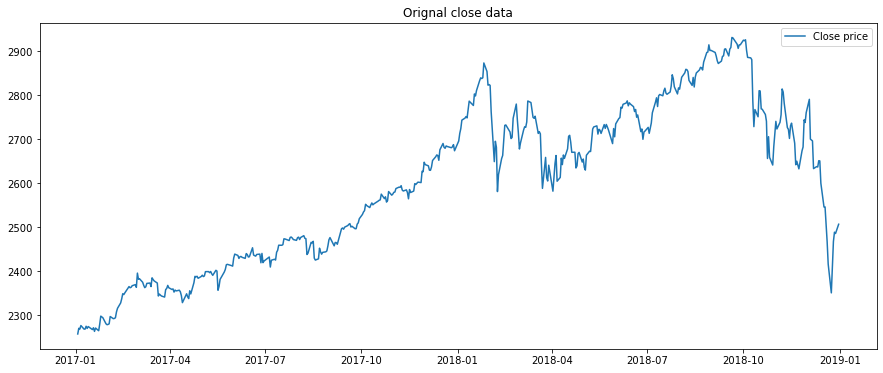

In [506]:
plt.figure(figsize=(15,6))
plt.plot(GSPC_noisy.iloc[0],label='Close price')#Not today's close price, is the yesterday's close price, to avoid future data
plt.title('Orignal close data')
plt.legend()

In [507]:
GSPC_T=GSPC.T
GSPC_pure=pd.DataFrame(columns=GSPC.columns)
for window in range(2,52):#SMA and EMA of the day, using the past n close price
    rolling_mean = GSPC_T['Close'].rolling(window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  GSPC_T['Close'].ewm(span=window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
GSPC_pure

Date,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,...,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-24,2018-12-26,2018-12-27,2018-12-28,2018-12-31
0,2257.830078,2264.290039,2269.875,2272.98999,2272.939941,2268.899902,2272.109985,2272.880005,2272.539917,2271.264893,...,2572.944946,2546.049927,2526.559937,2487.189941,2442.02002,2383.860107,2409.400024,2478.265015,2487.285034,2496.295044
1,2257.830078,2264.290039,2265.860026,2272.243327,2271.626628,2271.593262,2271.039958,2271.553304,2273.466634,2270.989909,...,2598.809977,2564.016602,2533.019938,2506.846598,2463.666667,2411.713379,2411.806722,2435.876709,2480.756673,2493.806722
2,2257.830078,2264.290039,2265.860026,2268.640015,2271.407471,2270.944946,2272.524963,2270.889954,2272.324951,2272.072449,...,2611.875,2585.647461,2549.752441,2516.619934,2484.289978,2435.525024,2425.710022,2431.062561,2448.342529,2487.280029
3,2257.830078,2264.290039,2265.860026,2268.640015,2268.691992,2270.905957,2271.819971,2272.107959,2271.639941,2271.437939,...,2616.856006,2598.731982,2569.909961,2533.285937,2496.619971,2457.652002,2441.96001,2438.334033,2441.998047,2460.044043
4,2257.830078,2264.290039,2265.860026,2268.640015,2268.691992,2268.726644,2271.641642,2271.589966,2272.529948,2271.014933,...,2620.333333,2605.073324,2583.436646,2552.828288,2513.841634,2472.366659,2459.32666,2449.771688,2446.235026,2452.806722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2257.830078,2264.427485,2266.016965,2268.935088,2268.92744,2268.922348,2269.957027,2270.026755,2270.630799,2270.301319,...,2716.633637,2709.530565,2701.090123,2691.353864,2679.906625,2666.206353,2657.935253,2650.889204,2644.007987,2638.293075
96,2257.830078,2264.424622,2266.013727,2268.928967,2268.92266,2268.918461,2269.951171,2270.02154,2270.624275,2270.296787,...,2717.947105,2710.935383,2702.609856,2693.010266,2681.729036,2668.233977,2660.048915,2653.060391,2646.230987,2640.541971
97,2257.830078,2264.421875,2266.010619,2268.923095,2268.91807,2268.914725,2269.945548,2270.016528,2270.618008,2270.292425,...,2719.229206,2712.306434,2704.092575,2694.625669,2683.505447,2670.209233,2662.108862,2655.17771,2648.400202,2642.738197
98,2257.830078,2264.419238,2266.007635,2268.917456,2268.913659,2268.911131,2269.940144,2270.011708,2270.611983,2270.288223,...,2720.480251,2713.644159,2705.538897,2696.200898,2685.236945,2672.13354,2664.116536,2657.242557,2650.516966,2644.882972


## MinMaxScaler

In [510]:
mm = MinMaxScaler()
noise_mm = mm.fit_transform(GSPC_noisy.T).T
prue_mm=mm.transform(GSPC_pure.T).T
prue_mm.shape

(100, 502)

In [511]:
train_cleaned_mm=np.reshape(prue_mm, (100, 502, 1))
train_mm=np.reshape(noise_mm, (100, 502, 1))

In [512]:
# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_cleaned_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

## LSTM

In [515]:
def set_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, input_shape=(502, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(64, activation='tanh',return_sequences = True))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.5))
    model.add(LSTM(64, activation='tanh',return_sequences = True))
    model.add(LSTM(128, activation='tanh',return_sequences = True))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 502, 128)          66560     
                                                                 
 lstm_17 (LSTM)              (None, 502, 64)           49408     
                                                                 
 batch_normalization_24 (Bat  (None, 502, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 251, 64)          0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 251, 64)           0         
                                                                 
 lstm_18 (LSTM)              (None, 251, 64)         

In [ ]:
callback = EarlyStopping(monitor='loss', patience=30)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=200, batch_size=8, verbose=1, callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 8s 378ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 2/200
10/10 [==============================] - 3s 262ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 3/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 4/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0595 - val_mse: 0.0595
Epoch 5/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 6/200
10/10 [==============================] - 3s 264ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 7/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0550 - val_mse: 0.0550
Epoch 8/200
10/10 [==============================] - 3s 262ms/step - 

10/10 [==============================] - 3s 260ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 63/200
10/10 [==============================] - 3s 261ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 64/200
10/10 [==============================] - 3s 261ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 65/200
10/10 [==============================] - 3s 261ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 66/200
10/10 [==============================] - 3s 262ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 67/200
10/10 [==============================] - 3s 262ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 68/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 69/200
10/10 [==============================] - 3s 263ms/step - loss:

In [18]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [11]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

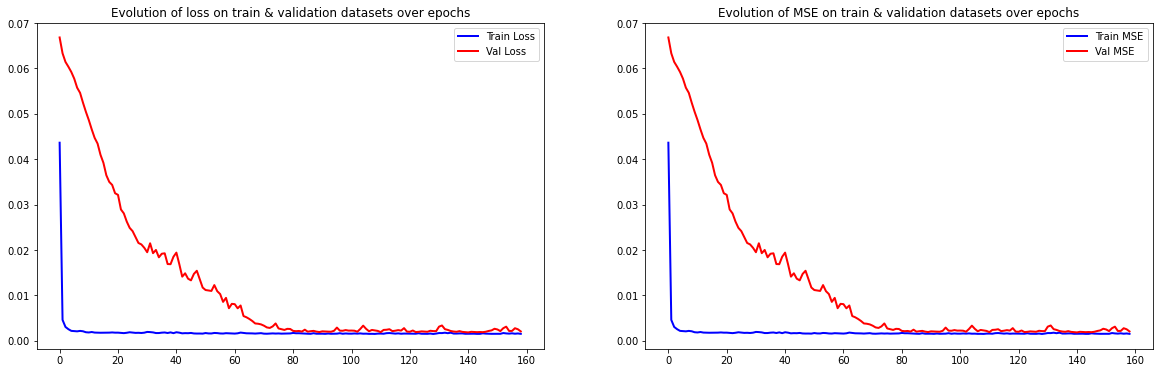

In [15]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mse = history_LSTM.history['mse']
epoch_val_mse = history_LSTM.history['val_mse']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [336]:
GSPC_test = pd.read_csv('GSPC_index_close_test123.csv')
Date=pd.to_datetime(GSPC_test['Date'])[0:450]
del GSPC_test['Date']
GSPC_test=GSPC_test[0:450]

1/1 [==============================] - 0s 53ms/step


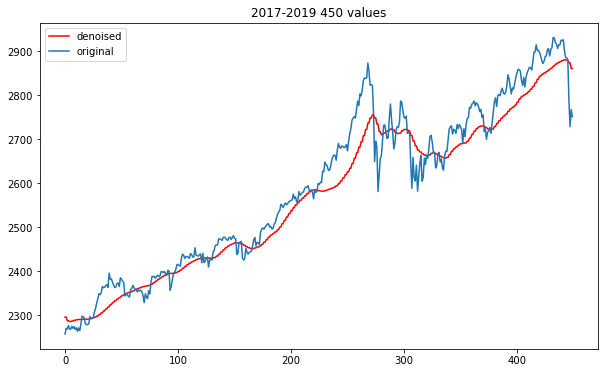

In [340]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=32)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((450,1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'])
plt.figure(figsize=(10,6))
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 450 values')
plt.legend(['denoised', 'original'], loc='upper left')

In [41]:
def set_model_encoding_mm():
    model = Sequential()
    #encoding
    model.add(Conv1D(128, kernel_size=3, activation='tanh', padding='same',input_shape=(450, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='sigmoid',padding='same'))
    model.add(BatchNormalization())
    #Use the normalization preprocessing of the data as mentioned before, so that the input x does not vary too much
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.5))
    #decoding
    model.add(Conv1D(64, kernel_size=3, activation='sigmoid', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='tanh',padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 450, 128)          512       
                                                                 
 conv1d_36 (Conv1D)          (None, 450, 64)           24640     
                                                                 
 batch_normalization_18 (Bat  (None, 450, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 225, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 225, 64)           0         
                                                                 
 conv1d_37 (Conv1D)          (None, 225, 64)          

In [42]:
callback = EarlyStopping(monitor='loss', patience=30)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=500, batch_size=4, verbose=1, callbacks=[callback])

Epoch 1/500
20/20 [==============================] - 2s 17ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0967 - val_mse: 0.0967
Epoch 2/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0946 - val_mse: 0.0946
Epoch 3/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0842 - val_mse: 0.0842
Epoch 4/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0900 - val_mse: 0.0900
Epoch 5/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0917 - val_mse: 0.0917
Epoch 6/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0936 - val_mse: 0.0936
Epoch 7/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0909 - val_mse: 0.0909
Epoch 8/500
20/20 [==============================] - 0s 10ms/step - loss: 0.

Epoch 63/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 64/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 65/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 66/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 67/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 68/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 69/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 70/500
20/20 [==============================] - 0s 10ms/step - lo

20/20 [==============================] - 0s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 125/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 126/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 127/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 128/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 129/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 130/500
20/20 [==============================] - 0s 9ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 131/500
20/20 [==============================] - 0s 10ms/step - loss: 0.

20/20 [==============================] - 0s 9ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 186/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 187/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 188/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 189/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 190/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 191/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 192/500
20/20 [==============================] - 0s 10ms/step - loss: 0

20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 247/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 248/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 249/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 250/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 251/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 252/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 253/500
20/20 [==============================] - 0s 11ms/step - loss: 

20/20 [==============================] - 0s 10ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 308/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 309/500
20/20 [==============================] - 0s 10ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0039 - val_mse: 0.0039


In [45]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

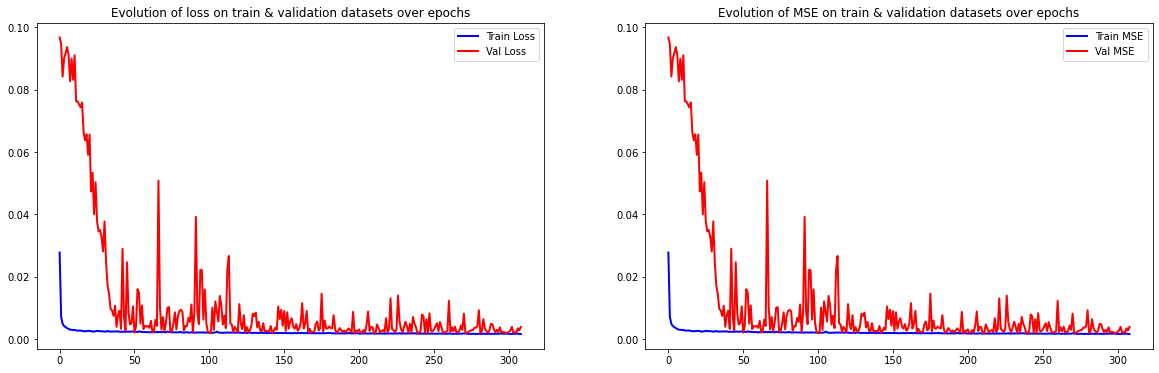

In [43]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mse = history_mm.history['mse']
epoch_val_mse = history_mm.history['val_mse']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [18]:
modelen_mm.load_weights('model_weights_mm.h5') 

1/1 [==============================] - 0s 17ms/step


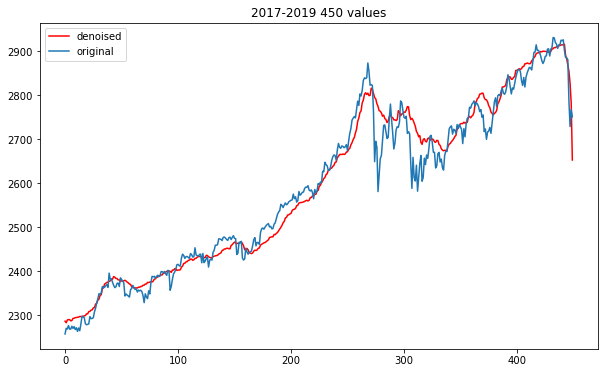

In [342]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T, batch_size=8)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((450,1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Close'])
plt.figure(figsize=(10,6))
plt.plot(pure_mm_cnn,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 450 values')
plt.legend(['denoised', 'original'], loc='upper left')

In [343]:
def log_return(dataset):
    daily_log_rets = np.diff(np.log(dataset).T)
    daily_log_rets=daily_log_rets.reshape(len(dataset)-1)
    daily_rets_series = pd.DataFrame(daily_log_rets)#calculate the log return
    return daily_rets_series

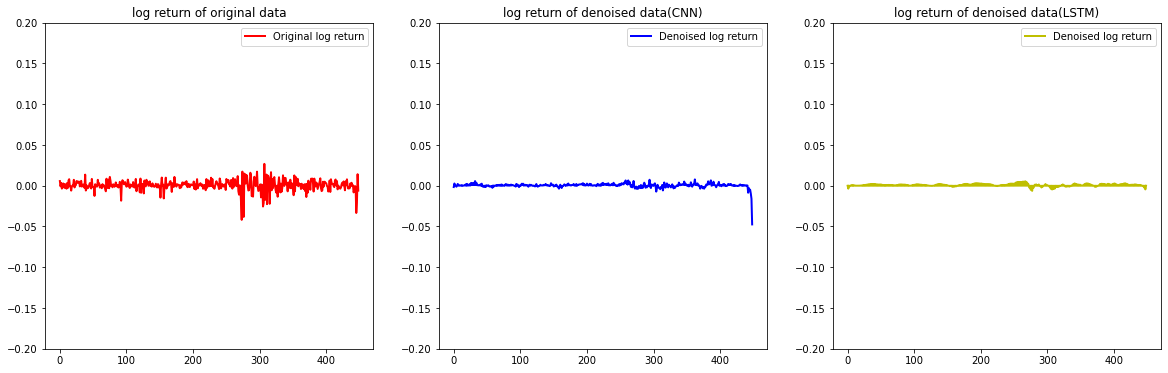

In [344]:
o=log_return(GSPC_test)
d_cnn=log_return(pure_mm_cnn)
d_lstm=log_return(pure_mm_lstm)

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(o, 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(d_cnn, 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.plot(d_lstm, 'y-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(LSTM)')
plt.legend(loc='best')

plt.show()

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
def svmf1(dataset,long_predict=10):
    daily_log_rets = np.diff(np.log(dataset).T)
    daily_log_rets=daily_log_rets.reshape(len(dataset)-1)
    daily_rets_series = pd.DataFrame(daily_log_rets)#calculate the log return
    f1=np.empty(0)
    for n in np.arange(0.0, 0.04, 0.0005):#get multiple threshold
        threshold = n
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(daily_rets_series)):
            if daily_rets_series.iloc[i,0]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(daily_rets_series.iloc[i,0])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(len(daily_rets_series)-long_predict):
            X=pd.concat([X, pd.DataFrame(daily_log_rets[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=5).mean())
    return f1

In [98]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_cnn)

In [102]:
denoised_svm

array([0.74064386, 0.62104628, 0.61806841, 0.73492958, 0.76635815,
       0.82909457, 0.8917505 , 0.92024145, 0.95158954, 0.95726358,
       0.96869215, 0.9743662 , 0.98293763, 0.98575453, 0.99146881,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [103]:
orignal_svm

array([0.53851107, 0.49577465, 0.43875252, 0.38720322, 0.46716298,
       0.54128773, 0.56696177, 0.58402414, 0.62965795, 0.64672032,
       0.66953722, 0.69802817, 0.72933602, 0.75501006, 0.77492958,
       0.79774648, 0.817666  , 0.85187123, 0.87464789, 0.88321932,
       0.89460765, 0.89460765, 0.90599598, 0.90885312, 0.92309859,
       0.92595573, 0.93162978, 0.94020121, 0.94873239, 0.95444668,
       0.96012072, 0.96012072, 0.96583501, 0.96583501, 0.96869215,
       0.97722334, 0.97722334, 0.98008048, 0.98008048, 0.98008048,
       0.98008048, 0.98008048, 0.98293763, 0.98861167, 0.98861167,
       0.99146881, 0.99146881, 0.99146881, 0.99146881, 0.99146881,
       0.99146881, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432596,
       0.99432596, 0.99432596, 0.99432596, 0.99432596, 0.99432

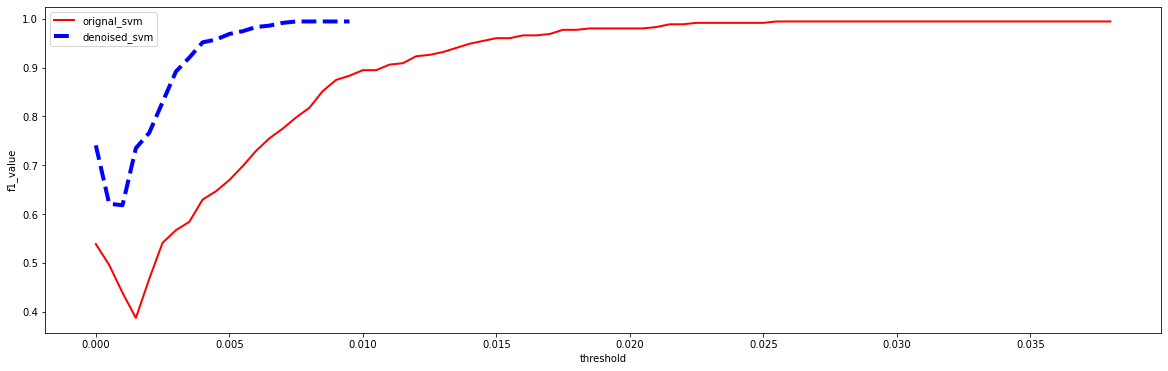

In [99]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.04, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.04, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.04, 0.005))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## LSTM

In [104]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_lstm)

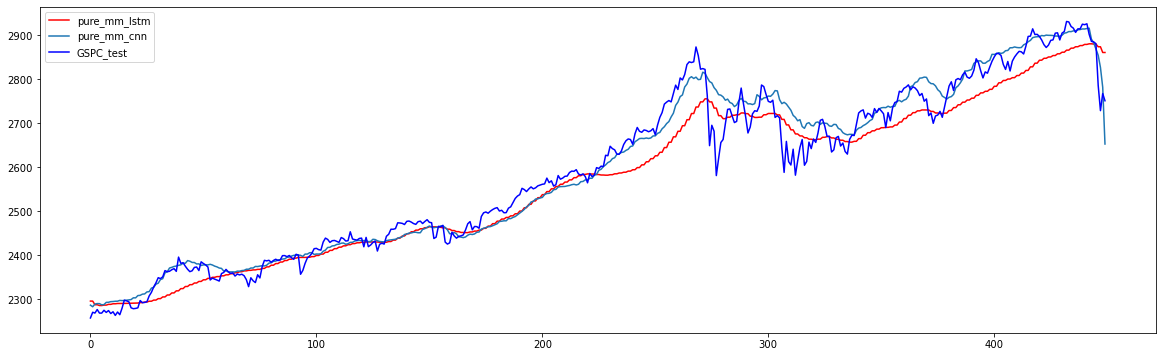

In [90]:
plt.figure(figsize=(20,6))
plt.plot(pure_mm_lstm,'r-',label='pure_mm_lstm')
plt.plot(pure_mm_cnn,label='pure_mm_cnn')
plt.plot(GSPC_test,'b-',label='GSPC_test')
plt.legend()

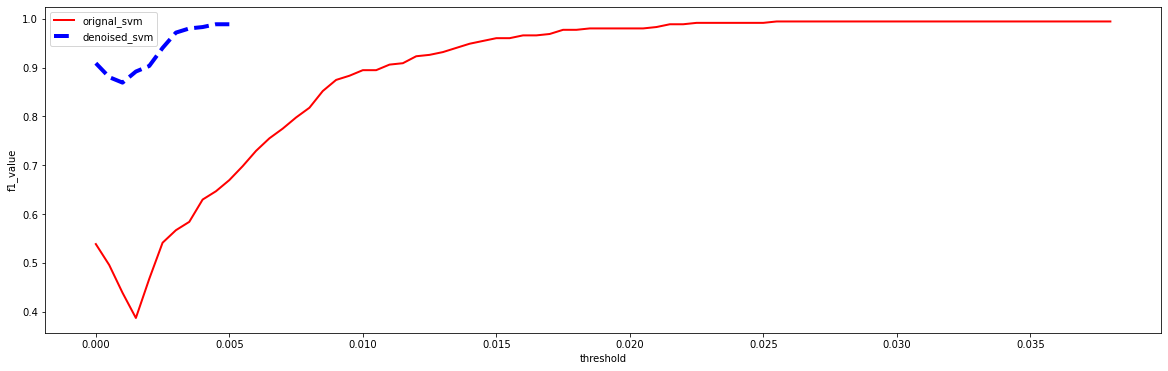

In [105]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.04, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.04, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.04, 0.005))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [348]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands
    #tem=pd.DataFrame([np.nan],columns=close_prices.columns)
    #rolling_mean=pd.concat([tem, close_prices.rolling(window).mean()],ignore_index=True)
    #rolling_std=pd.concat([tem, close_prices.rolling(window).std()],ignore_index=True)
    rolling_mean = close_prices.rolling(window).mean()
    rolling_std = close_prices.rolling(window).std()
    
    #upper_band=pd.concat([tem, rolling_mean + (rolling_std * no_of_stdev)],ignore_index=True)
    #lower_band=pd.concat([tem, rolling_mean - (rolling_std * no_of_stdev)],ignore_index=True)
    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean.shift(1), upper_band.shift(1), lower_band.shift(1)

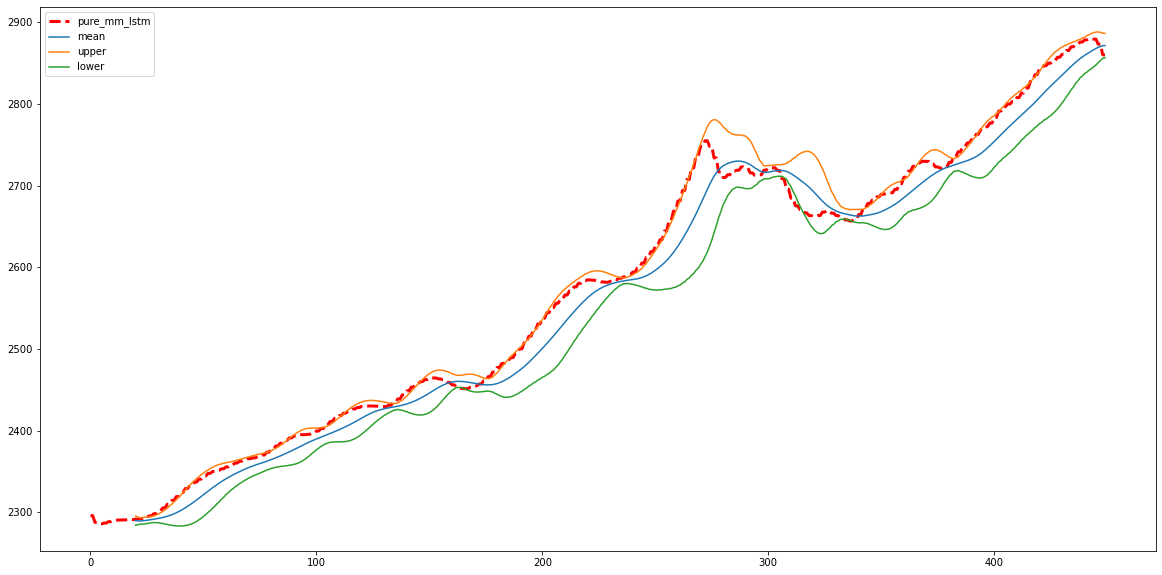

In [349]:
pure_mm_lstm_bb=pd.DataFrame(columns=['mean','upper','lower'])
pure_mm_lstm_bb['mean'],pure_mm_lstm_bb['upper'],pure_mm_lstm_bb['lower']=bbands(pure_mm_lstm,20,2)
plt.figure(figsize=(20,10))
plt.plot(pure_mm_lstm,label='pure_mm_lstm', color='red', linewidth=3.0, linestyle='--')
plt.plot(pure_mm_lstm_bb['mean'],label='mean')
plt.plot(pure_mm_lstm_bb['upper'],label='upper')
plt.plot(pure_mm_lstm_bb['lower'],label='lower')
plt.legend(loc='best')

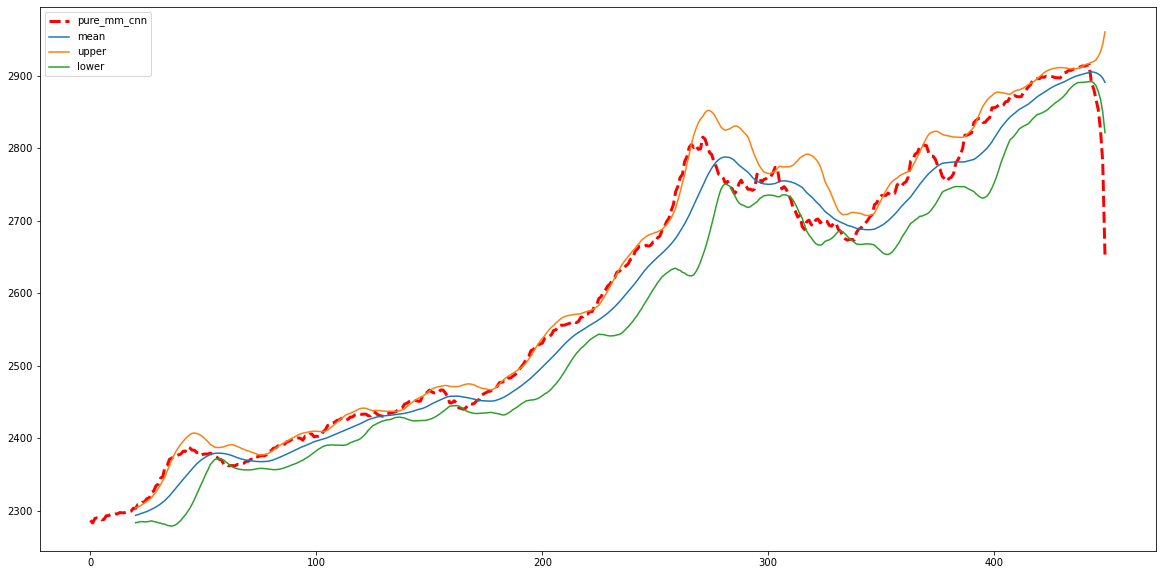

In [350]:
pure_mm_cnn_bb=pd.DataFrame(columns=['mean','upper','lower'])
pure_mm_cnn_bb['mean'],pure_mm_cnn_bb['upper'],pure_mm_cnn_bb['lower']=bbands(pure_mm_cnn,20,2)
plt.figure(figsize=(20,10))
plt.plot(pure_mm_cnn,label='pure_mm_cnn', color='red', linewidth=3.0, linestyle='--')
plt.plot(pure_mm_cnn_bb['mean'],label='mean')
plt.plot(pure_mm_cnn_bb['upper'],label='upper')
plt.plot(pure_mm_cnn_bb['lower'],label='lower')
plt.legend(loc='best')

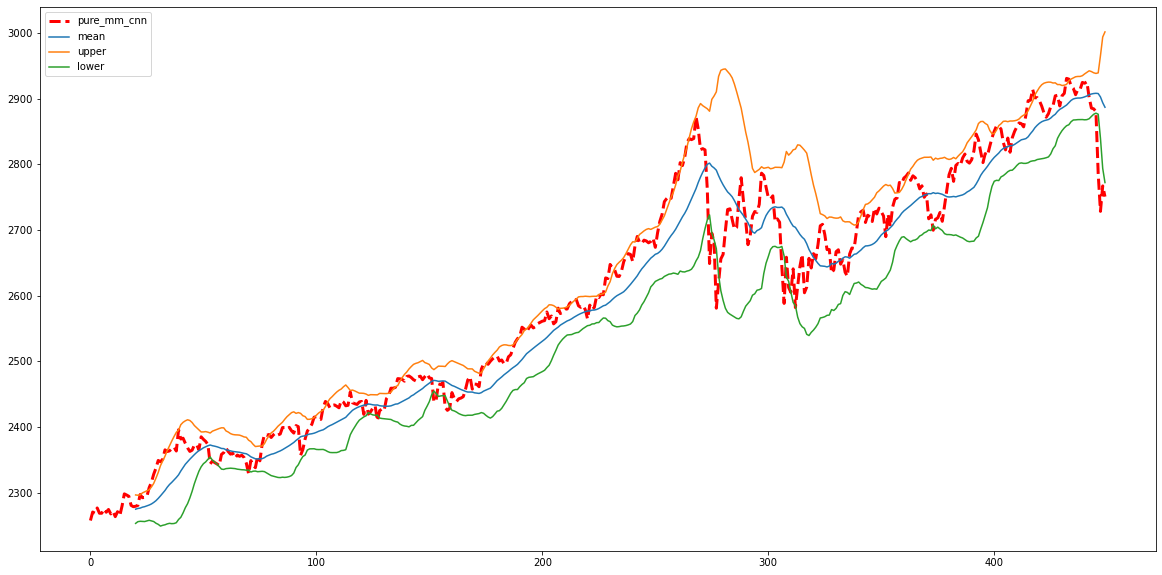

In [351]:
GSPC_test_bb=pd.DataFrame(columns=['mean','upper','lower'])
GSPC_test_bb['mean'],GSPC_test_bb['upper'],GSPC_test_bb['lower']=bbands(GSPC_test,20,2)
plt.figure(figsize=(20,10))
plt.plot(GSPC_test,label='pure_mm_cnn', color='red', linewidth=3.0, linestyle='--')
plt.plot(GSPC_test_bb['mean'],label='mean')
plt.plot(GSPC_test_bb['upper'],label='upper')
plt.plot(GSPC_test_bb['lower'],label='lower')
plt.legend(loc='best')

In [352]:
def buy_signal_function(dataset,dataset1,dataset2,dataset3,Date):
    buy_signal=pd.DataFrame(columns=['Date','Price','Price1','Price2','Price3'])
    dataset_bb=pd.DataFrame(columns=['mean','upper','lower'])
    dataset_bb['mean'],dataset_bb['upper'],dataset_bb['lower']=bbands(dataset,20,2)
    for i in range(0,len(dataset)):
        if (dataset.iloc[i,0]<=dataset_bb.iloc[i,2]):
            if dataset.iloc[i-1,0]>dataset_bb.iloc[i-1,2]:
                tem=pd.DataFrame([Date[i],dataset.iloc[i,0],dataset1.iloc[i,0],dataset2.iloc[i,0],dataset3.iloc[i,0]],index=['Date','Price','Price1','Price2','Price3'])
                buy_signal=buy_signal.append(tem.T)
    return buy_signal

In [353]:
GSPC_test_signal=buy_signal_function(GSPC_test,GSPC_test,pure_mm_cnn,pure_mm_lstm,Date)
GSPC_test_signal

,Date,Price,Price1,Price2,Price3
0,2017-03-21 00:00:00,2344.02002,2344.02002,2379.64502,2347.819336
0,2017-04-13 00:00:00,2328.949951,2328.949951,2368.456787,2365.937256
0,2017-06-29 00:00:00,2419.699951,2419.699951,2431.131348,2430.421387
0,2017-07-06 00:00:00,2409.75,2409.75,2433.075928,2430.191162
0,2017-08-10 00:00:00,2438.209961,2438.209961,2462.711426,2464.671875
0,2017-08-17 00:00:00,2430.01001,2430.01001,2463.149902,2462.463135
0,2018-02-05 00:00:00,2648.939941,2648.939941,2794.422363,2748.230957
0,2018-03-22 00:00:00,2643.689941,2643.689941,2744.239746,2708.557373
0,2018-03-27 00:00:00,2612.620117,2612.620117,2736.313477,2695.991211
0,2018-04-02 00:00:00,2581.879883,2581.879883,2713.07959,2675.464111


In [354]:
pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn,GSPC_test,pure_mm_cnn,pure_mm_lstm,Date)
pure_mm_cnn_signal

,Date,Price,Price1,Price2,Price3
0,2017-03-27 00:00:00,2371.206299,2341.590088,2371.206299,2351.74292
0,2017-08-25 00:00:00,2442.000488,2443.050049,2442.000488,2453.755615
0,2018-02-16 00:00:00,2746.862061,2732.219971,2746.862061,2713.460205
0,2018-03-28 00:00:00,2729.309814,2605.0,2729.309814,2684.802979
0,2018-04-30 00:00:00,2685.736572,2648.050049,2685.736572,2661.223389
0,2018-10-05 00:00:00,2890.622803,2885.570068,2890.622803,2880.049561


In [355]:
pure_mm_lstm_signal=buy_signal_function(pure_mm_lstm,GSPC_test,pure_mm_cnn,pure_mm_lstm,Date)
pure_mm_lstm_signal

,Date,Price,Price1,Price2,Price3
0,2017-08-28 00:00:00,2451.903564,2444.23999,2441.4104,2451.903564
0,2018-03-22 00:00:00,2708.557373,2643.689941,2744.239746,2708.557373
0,2018-05-02 00:00:00,2658.217773,2635.669922,2675.311035,2658.217773


In [356]:
pure_mm_lstm_signal.set_index('Date', inplace=True)
pure_mm_lstm_signal

,Price,Price1,Price2,Price3
Date,,,,
2017-08-28,2451.903564,2444.23999,2441.4104,2451.903564
2018-03-22,2708.557373,2643.689941,2744.239746,2708.557373
2018-05-02,2658.217773,2635.669922,2675.311035,2658.217773


In [406]:
pure_mm_lstm

,Close
0,2296.149902
1,2296.149902
2,2287.856689
3,2287.856689
4,2286.055420
...,...
445,2879.543701
446,2873.344238
447,2873.344238
448,2860.333984


In [407]:
pure_mm_lstm2=pure_mm_lstm.copy()
pure_mm_lstm2['Date']=Date
pure_mm_lstm2.set_index('Date', inplace=True)
pure_mm_lstm2['mean'], pure_mm_lstm2['upper'], pure_mm_lstm2['lower'] = bbands(pure_mm_lstm2, 20, no_of_stdev=2)
pure_mm_lstm2

,Close,mean,upper,lower
Date,,,,
2017-01-03,2296.149902,NaN,NaN,NaN
2017-01-04,2296.149902,NaN,NaN,NaN
2017-01-05,2287.856689,NaN,NaN,NaN
2017-01-06,2287.856689,NaN,NaN,NaN
2017-01-09,2286.055420,NaN,NaN,NaN
...,...,...,...,...
2018-10-09,2879.543701,2868.059387,2888.194314,2847.924460
2018-10-10,2873.344238,2869.528735,2888.413023,2850.644448
2018-10-11,2873.344238,2870.524194,2887.873002,2853.175386


In [408]:
# Compute sides
pure_mm_lstm2['side'] = np.nan 

long_signals = (pure_mm_lstm2.iloc[:,0] <= pure_mm_lstm2['lower']) 
short_signals = (pure_mm_lstm2.iloc[:,0] >= pure_mm_lstm2['upper']) 

pure_mm_lstm2.loc[long_signals, 'side'] = 1
pure_mm_lstm2.loc[short_signals, 'side'] = -1

print(pure_mm_lstm2.side.value_counts())


-1.0    118
 1.0     14
Name: side, dtype: int64


In [409]:
# Log Returns
pure_mm_lstm2['log_ret'] = np.log(pure_mm_lstm2.iloc[:,0]).diff()

# Momentum
pure_mm_lstm2['mom1'] = pure_mm_lstm2.iloc[:,0].pct_change(periods=1)#computes the percentage change between the current and a prior element
pure_mm_lstm2['mom2'] = pure_mm_lstm2.iloc[:,0].pct_change(periods=2)
pure_mm_lstm2['mom3'] = pure_mm_lstm2.iloc[:,0].pct_change(periods=3)
pure_mm_lstm2['mom4'] = pure_mm_lstm2.iloc[:,0].pct_change(periods=4)
pure_mm_lstm2['mom5'] = pure_mm_lstm2.iloc[:,0].pct_change(periods=5)
pure_mm_lstm2['mom6'] = pure_mm_lstm2.iloc[:,0].pct_change(periods=6)
pure_mm_lstm2

,Close,mean,upper,lower,side,log_ret,mom1,mom2,mom3,mom4,mom5,mom6
Date,,,,,,,,,,,,
2017-01-03,2296.149902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,2296.149902,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2017-01-05,2287.856689,NaN,NaN,NaN,NaN,-0.003618,-0.003612,-0.003612,NaN,NaN,NaN,NaN
2017-01-06,2287.856689,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.003612,-0.003612,NaN,NaN,NaN
2017-01-09,2286.055420,NaN,NaN,NaN,NaN,-0.000788,-0.000787,-0.000787,-0.004396,-0.004396,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-09,2879.543701,2868.059387,2888.194314,2847.924460,NaN,0.000000,0.000000,-0.000176,-0.000176,0.000303,0.000303,0.001223
2018-10-10,2873.344238,2869.528735,2888.413023,2850.644448,NaN,-0.002155,-0.002153,-0.002153,-0.002328,-0.002328,-0.001851,-0.001851
2018-10-11,2873.344238,2870.524194,2887.873002,2853.175386,NaN,0.000000,0.000000,-0.002153,-0.002153,-0.002328,-0.002328,-0.001851


In [410]:
# Volatility
window_stdev = 20
pure_mm_lstm2['volatility'] = pure_mm_lstm2['log_ret'].rolling(window=window_stdev).std().shift(1)


window_autocorr = 20
#compute the lag-N autocorrelation.
pure_mm_lstm2['autocorr_1'] = pure_mm_lstm2['log_ret'].rolling(window=window_autocorr).apply(lambda x: x.autocorr(lag=1), raw=False).shift(1)
pure_mm_lstm2['autocorr_2'] = pure_mm_lstm2['log_ret'].rolling(window=window_autocorr).apply(lambda x: x.autocorr(lag=2), raw=False).shift(1)
pure_mm_lstm2['autocorr_3'] = pure_mm_lstm2['log_ret'].rolling(window=window_autocorr).apply(lambda x: x.autocorr(lag=3), raw=False).shift(1)
pure_mm_lstm2['autocorr_4'] = pure_mm_lstm2['log_ret'].rolling(window=window_autocorr).apply(lambda x: x.autocorr(lag=4), raw=False).shift(1)
pure_mm_lstm2['autocorr_5'] = pure_mm_lstm2['log_ret'].rolling(window=window_autocorr).apply(lambda x: x.autocorr(lag=5), raw=False).shift(1)
pure_mm_lstm2['autocorr_6'] = pure_mm_lstm2['log_ret'].rolling(window=window_autocorr).apply(lambda x: x.autocorr(lag=6), raw=False).shift(1)

# Get the various log -t returns
pure_mm_lstm2['log_t1'] = pure_mm_lstm2['log_ret'].shift(1)
pure_mm_lstm2['log_t2'] = pure_mm_lstm2['log_ret'].shift(2)
pure_mm_lstm2['log_t3'] = pure_mm_lstm2['log_ret'].shift(3)
pure_mm_lstm2['log_t4'] = pure_mm_lstm2['log_ret'].shift(4)
pure_mm_lstm2['log_t5'] = pure_mm_lstm2['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 12
slow_window = 26

pure_mm_lstm2['fast_mavg'] = pure_mm_lstm2['Close'].rolling(window=fast_window).mean().shift(1)
pure_mm_lstm2['slow_mavg'] = pure_mm_lstm2['Close'].rolling(window=slow_window).mean().shift(1)

In [411]:
# Add Trending signals  macd
pure_mm_lstm2['sma'] = np.nan

long_signals = pure_mm_lstm2['fast_mavg'] >= pure_mm_lstm2['slow_mavg']
short_signals = pure_mm_lstm2['fast_mavg'] < pure_mm_lstm2['slow_mavg']
pure_mm_lstm2.loc[long_signals, 'sma'] = 1
pure_mm_lstm2.loc[short_signals, 'sma'] = -1

In [412]:
pure_mm_lstm3=pure_mm_lstm2.iloc[:,4:].copy()

In [440]:
pure_mm_lstm3

,side,log_ret,mom1,mom2,mom3,mom4,mom5,mom6,volatility,autocorr_1,...,autocorr_5,autocorr_6,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,-0.003618,-0.003612,-0.003612,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,0.000000,0.000000,-0.003612,-0.003612,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.003618,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,NaN,-0.000788,-0.000787,-0.000787,-0.004396,-0.004396,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,-0.003618,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-09,NaN,0.000000,0.000000,-0.000176,-0.000176,0.000303,0.000303,0.001223,0.000645,-0.749898,...,-0.741809,0.797806,-0.000175,0.000000,0.000479,0.000000,0.000920,2875.150330,2862.597252,1.0
2018-10-10,NaN,-0.002155,-0.002153,-0.002153,-0.002328,-0.002328,-0.001851,-0.001851,0.000645,-0.651494,...,-0.725641,0.797806,0.000000,-0.000175,0.000000,0.000479,0.000000,2876.307454,2864.269419,1.0
2018-10-11,NaN,0.000000,0.000000,-0.002153,-0.002153,-0.002328,-0.002328,-0.001851,0.000860,-0.326558,...,-0.291630,0.420373,-0.002155,0.000000,-0.000175,0.000000,0.000479,2876.571798,2865.441848,1.0


In [420]:
pure_mm_lstm3[~np.isnan(pure_mm_lstm3['side'])]


,side,log_ret,mom1,mom2,mom3,mom4,mom5,mom6,volatility,autocorr_1,...,autocorr_5,autocorr_6,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-09,-1.0,0.000816,0.000816,0.000816,0.001403,0.001403,0.001790,0.001790,0.000242,-0.521855,...,-0.478201,0.128220,0.000000,0.000586,0.000000,0.000387,0.000000,2291.928548,2290.629338,1.0
2017-02-10,-1.0,0.000000,0.000000,0.000816,0.000816,0.001403,0.001403,0.001790,0.000276,-0.507280,...,-0.428716,0.090078,0.000816,0.000000,0.000586,0.000000,0.000387,2292.345846,2290.618296,1.0
2017-02-13,-1.0,0.001112,0.001113,0.001113,0.001930,0.001930,0.002517,0.002517,0.000276,-0.498657,...,-0.441415,0.090078,0.000000,0.000816,0.000000,0.000586,0.000000,2292.763143,2290.607253,1.0
2017-02-14,-1.0,0.000000,0.000000,0.001113,0.001113,0.001930,0.001930,0.002517,0.000323,-0.466238,...,-0.443754,0.453218,0.001112,0.000000,0.000816,0.000000,0.000586,2293.379272,2291.013447,1.0
2017-02-15,-1.0,0.001433,0.001434,0.001434,0.002549,0.002549,0.003367,0.003367,0.000323,-0.427640,...,-0.484830,0.453218,0.000000,0.001112,0.000000,0.000816,0.000000,2293.995402,2291.419640,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-08,-1.0,0.002831,0.002835,0.002835,0.005334,0.005334,0.006941,0.006941,0.001064,-0.923683,...,-0.919839,0.937518,0.000000,0.002490,0.000000,0.001596,0.000000,2770.195760,2751.637489,1.0
2018-08-10,-1.0,0.001911,0.001912,0.001912,0.004753,0.004753,0.007257,0.007257,0.001096,-0.903082,...,-0.904591,0.870483,0.000000,0.002831,0.000000,0.002490,0.000000,2776.016886,2757.007118,1.0
2018-08-28,-1.0,0.002879,0.002883,0.002883,0.005051,0.005051,0.007016,0.007016,0.001013,-0.854986,...,-0.831657,0.673913,0.000000,0.002159,0.000000,0.001954,0.000000,2806.904989,2788.780856,1.0


In [442]:
pure_mm_lstm.index=pure_mm_lstm3.index
pure_mm_lstm

,Close
Date,
2017-01-03,2296.149902
2017-01-04,2296.149902
2017-01-05,2287.856689
2017-01-06,2287.856689
2017-01-09,2286.055420
...,...
2018-10-09,2879.543701
2018-10-10,2873.344238
2018-10-11,2873.344238


In [445]:
# Initiate short and long windows
short_window = 12
long_window = 26

# Initialise the `signals` dataframeand add the `signal` column
signals = pd.DataFrame(index=pure_mm_lstm2.index)
signals['signal'] = 0.0

# Calculate short term simple moving averages
signals['short_mavg'] = pure_mm_lstm2['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Calculate long term simple moving averages
signals['long_mavg'] = pure_mm_lstm2['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# 生成信号
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# 生成交易命令
signals['positions'] = signals['signal'].diff()

# 输出`signals`
signals

,signal,short_mavg,long_mavg,positions
Date,,,,
2017-01-03,0.0,2296.149902,2296.149902,NaN
2017-01-04,0.0,2296.149902,2296.149902,0.0
2017-01-05,0.0,2293.385498,2293.385498,0.0
2017-01-06,0.0,2292.003296,2292.003296,0.0
2017-01-09,0.0,2290.813721,2290.813721,0.0
...,...,...,...,...
2018-10-09,1.0,2876.307454,2864.269419,0.0
2018-10-10,1.0,2876.571798,2865.441848,0.0
2018-10-11,1.0,2876.836141,2866.614277,0.0


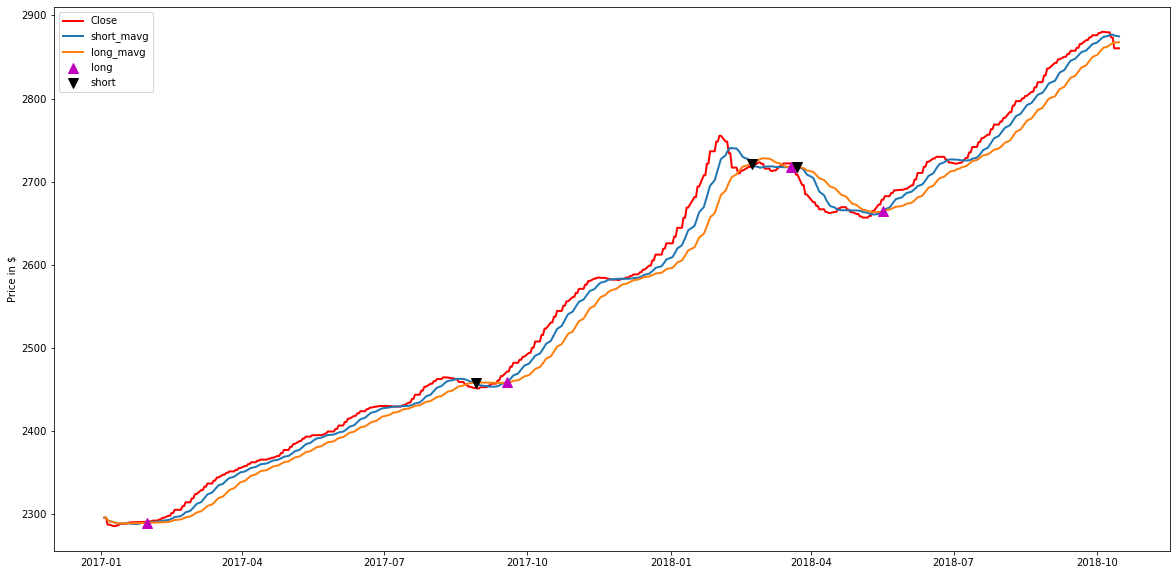

In [438]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(111,  ylabel='Price in $')

# plot close price
plt.plot(pure_mm_lstm2['Close'], color='r', lw=2,label='Close')
# plot short/long_ma lines
plt.plot(signals[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
# 绘制买入信号
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m',label='long')
         
# 绘制卖出信号
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         
# 显示做图
plt.show()